In [1]:
import pathlib
import polars as pl

In [2]:
path_data = pathlib.Path().cwd().parent / "data" 

df = pl.read_csv(path_data / 'train.csv')

In [3]:
df.shape

(8000, 17)

In [4]:
df.describe()

statistic,Customer_ID,Age,Gender,Location,Subscription_Type,Account_Age_Months,Monthly_Spending,Total_Usage_Hours,Support_Calls,Late_Payments,Streaming_Usage,Discount_Used,Satisfaction_Score,Last_Interaction_Type,Complaint_Tickets,Promo_Opted_In,Churn
str,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64
"""count""",8000.0,8000.0,"""8000""","""8000""","""8000""",8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,"""8000""",8000.0,8000.0,8000.0
"""null_count""",0.0,0.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0
"""mean""",5000.5,43.54225,null,null,null,30.163875,104.804641,254.326625,4.45325,1.9925,49.798,49.42825,5.462375,null,1.9705,0.49975,0.313125
"""std""",2309.54541,14.909242,null,null,null,16.942407,54.643255,140.855632,2.88892,1.39971,28.965468,28.662071,2.879865,null,1.413375,0.500031,0.463794
"""min""",1001.0,18.0,"""Female""","""California""","""Basic""",1.0,10.09,10.0,0.0,0.0,0.0,0.0,1.0,"""Negative""",0.0,0.0,0.0
"""25%""",3001.0,31.0,null,null,null,15.0,57.64,133.0,2.0,1.0,24.0,25.0,3.0,null,1.0,0.0,0.0
"""50%""",5001.0,44.0,null,null,null,30.0,104.71,257.0,4.0,2.0,51.0,50.0,5.0,null,2.0,0.0,0.0
"""75%""",7000.0,57.0,null,null,null,45.0,151.69,376.0,7.0,3.0,75.0,74.0,8.0,null,3.0,1.0,1.0
"""max""",9000.0,69.0,"""Male""","""Texas""","""Premium""",59.0,199.94,499.0,9.0,4.0,99.0,99.0,10.0,"""Positive""",4.0,1.0,1.0


In [5]:
# Variáveis demográficas
demographic_vars = ['Age', 'Gender', 'Location']

# Variáveis categóricas
categorical_vars = [
    'Gender',
    'Location', 
    'Subscription_Type',
    'Last_Interaction_Type'
]

# Variáveis binárias (podem ser tratadas como categóricas ou numéricas)
binary_vars = [
    'Promo_Opted_In',  # 0/1
    'Churn'            # 0/1 - Target variable
]

# Variáveis numéricas contínuas
continuous_vars = [
    'Age',
    'Account_Age_Months',
    'Monthly_Spending',
    'Total_Usage_Hours',
    'Streaming_Usage',     # Porcentagem (0-99%)
    'Discount_Used',       # Porcentagem (0-99%)
    'Satisfaction_Score'   # Escala 1-10
]

# Variáveis numéricas discretas (contagens)
discrete_vars = [
    'Support_Calls',       # Número de chamadas
    'Late_Payments',       # Número de pagamentos atrasados
    'Complaint_Tickets'    # Número de tickets de reclamação
]

# Todas as variáveis numéricas (contínuas + discretas + binárias)
numeric_vars = continuous_vars + discrete_vars + binary_vars

# Variável alvo
target_var = 'Churn'

# Variáveis explicativas (features)
feature_vars = [col for col in df.columns if col not in ['Customer_ID', 'Churn']]

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List, Optional

# Configuração de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [7]:
from explor_plots_funcs import (
    plot_target_distribution,
    plot_categorical_analysis,
    plot_numerical_distributions,
    plot_boxplots_by_target,
    plot_correlation_matrix,
    plot_pairplot_sample
)

def comprehensive_eda(df: pl.DataFrame):
    """Executa análise exploratória completa"""
    print("=== ANÁLISE EXPLORATÓRIA DE DADOS ===\n")
    
    # Importar pandas para os plots
    import pandas as pd
    
    # 1. Distribuição do target
    print("1. Distribuição da Variável Target")
    plot_target_distribution(df)
    
    # 2. Análise categóricas
    print("\n2. Análise das Variáveis Categóricas")
    plot_categorical_analysis(df, categorical_vars)
    
    # 3. Distribuições numéricas
    print("\n3. Distribuições das Variáveis Numéricas")
    plot_numerical_distributions(df, numeric_vars)
    
    # 4. Boxplots
    print("\n4. Boxplots por Target")
    plot_boxplots_by_target(df, numeric_vars)
    
    # 5. Matriz de correlação
    print("\n5. Matriz de Correlação")
    plot_correlation_matrix(df, numeric_vars)
    
    # 6. Pairplot de variáveis selecionadas
    print("\n6. Pairplot - Variáveis Importantes")
    important_vars = ['Age', 'Monthly_Spending', 'Satisfaction_Score', 'Support_Calls', 'Late_Payments']
    plot_pairplot_sample(df, important_vars)
    
    print("\n=== ANÁLISE CONCLUÍDA ===")

<Axes: >

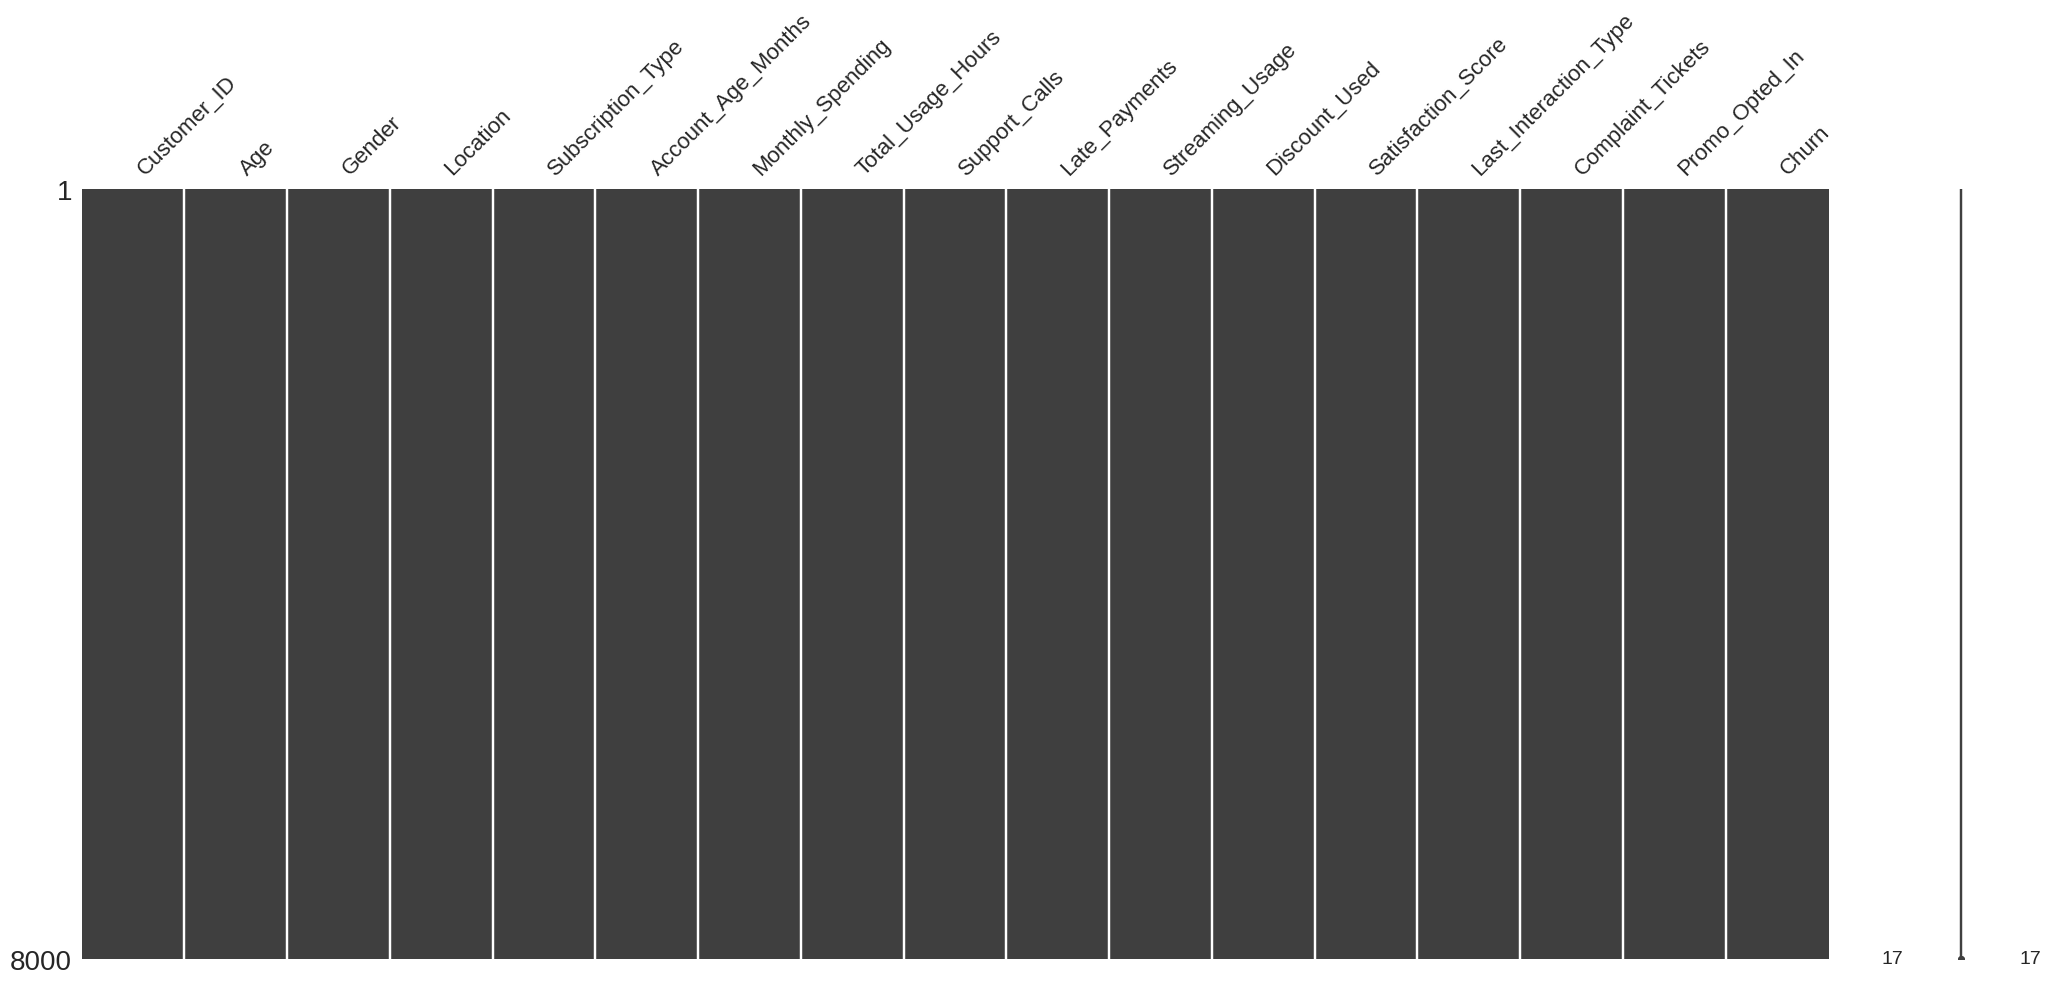

In [10]:
import missingno as msno

# Assuming 'df' is your DataFrame
msno.matrix(df.to_pandas())


=== ANÁLISE EXPLORATÓRIA DE DADOS ===

1. Distribuição da Variável Target


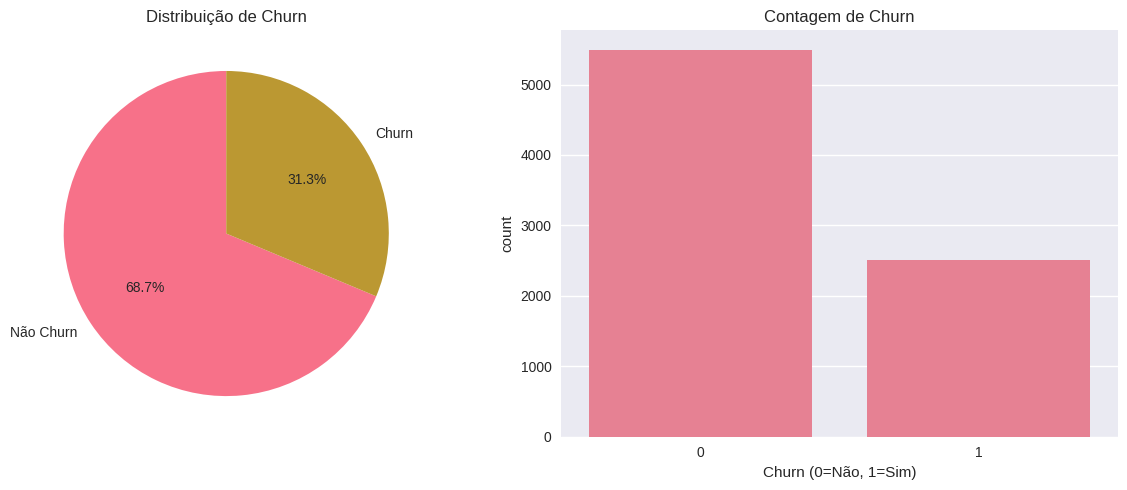

Taxa de Churn: 31.31%
Total de clientes: 8000
Clientes que fizeram churn: 2505
Clientes que permaneceram: 5495

2. Análise das Variáveis Categóricas


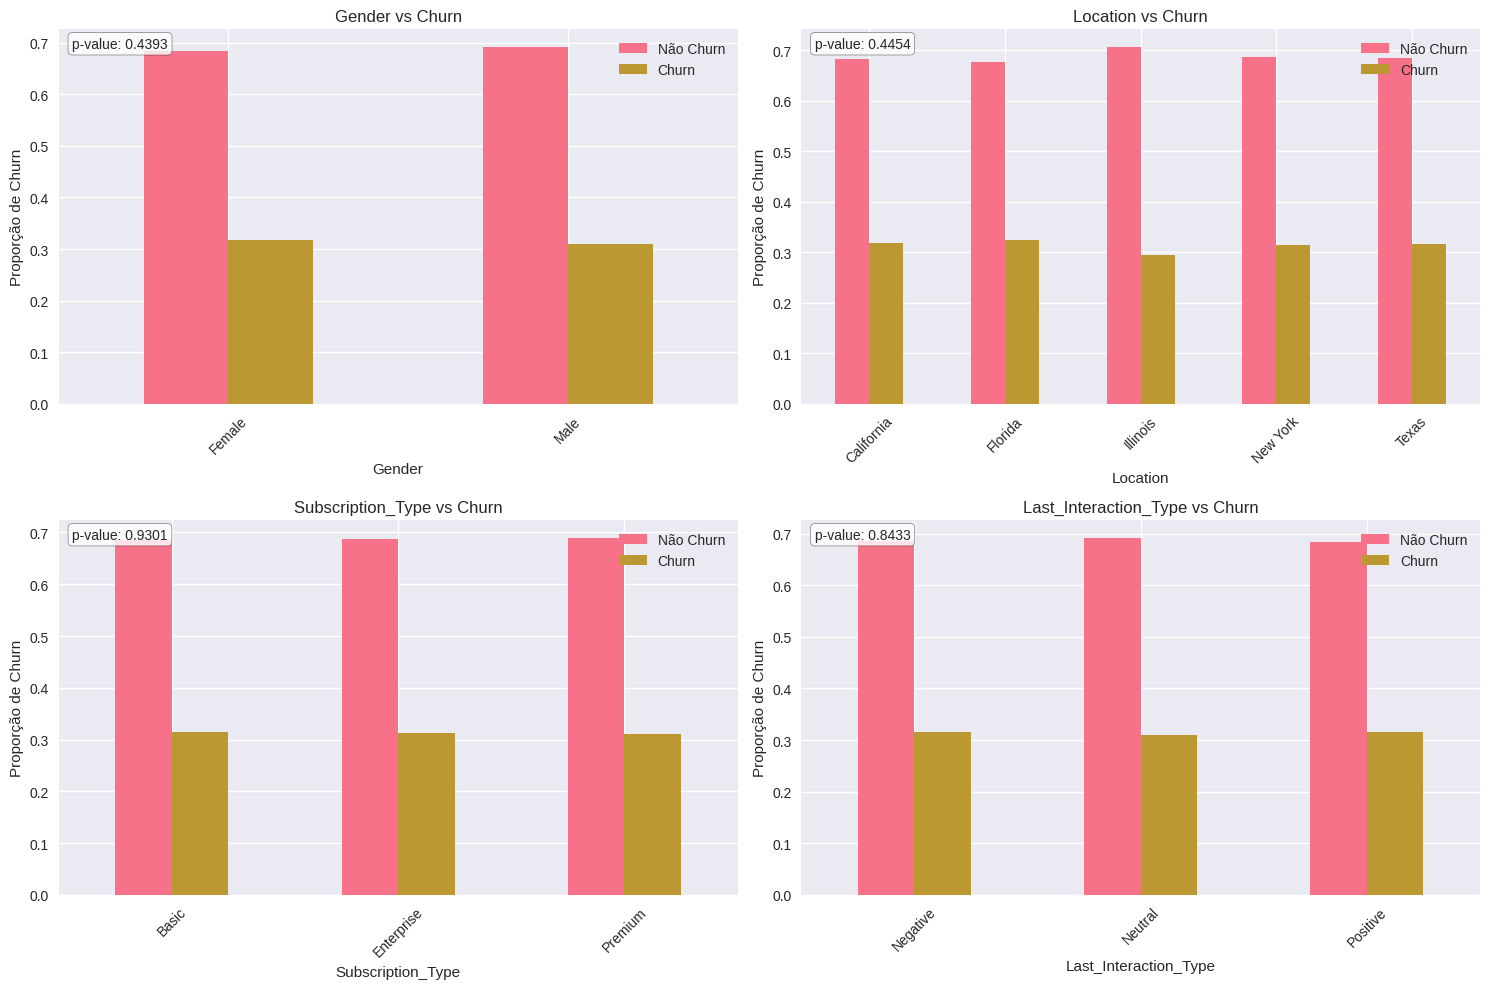


3. Distribuições das Variáveis Numéricas


/home/esdrasgc/Insper/8_semestre/redes-neurais/env/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


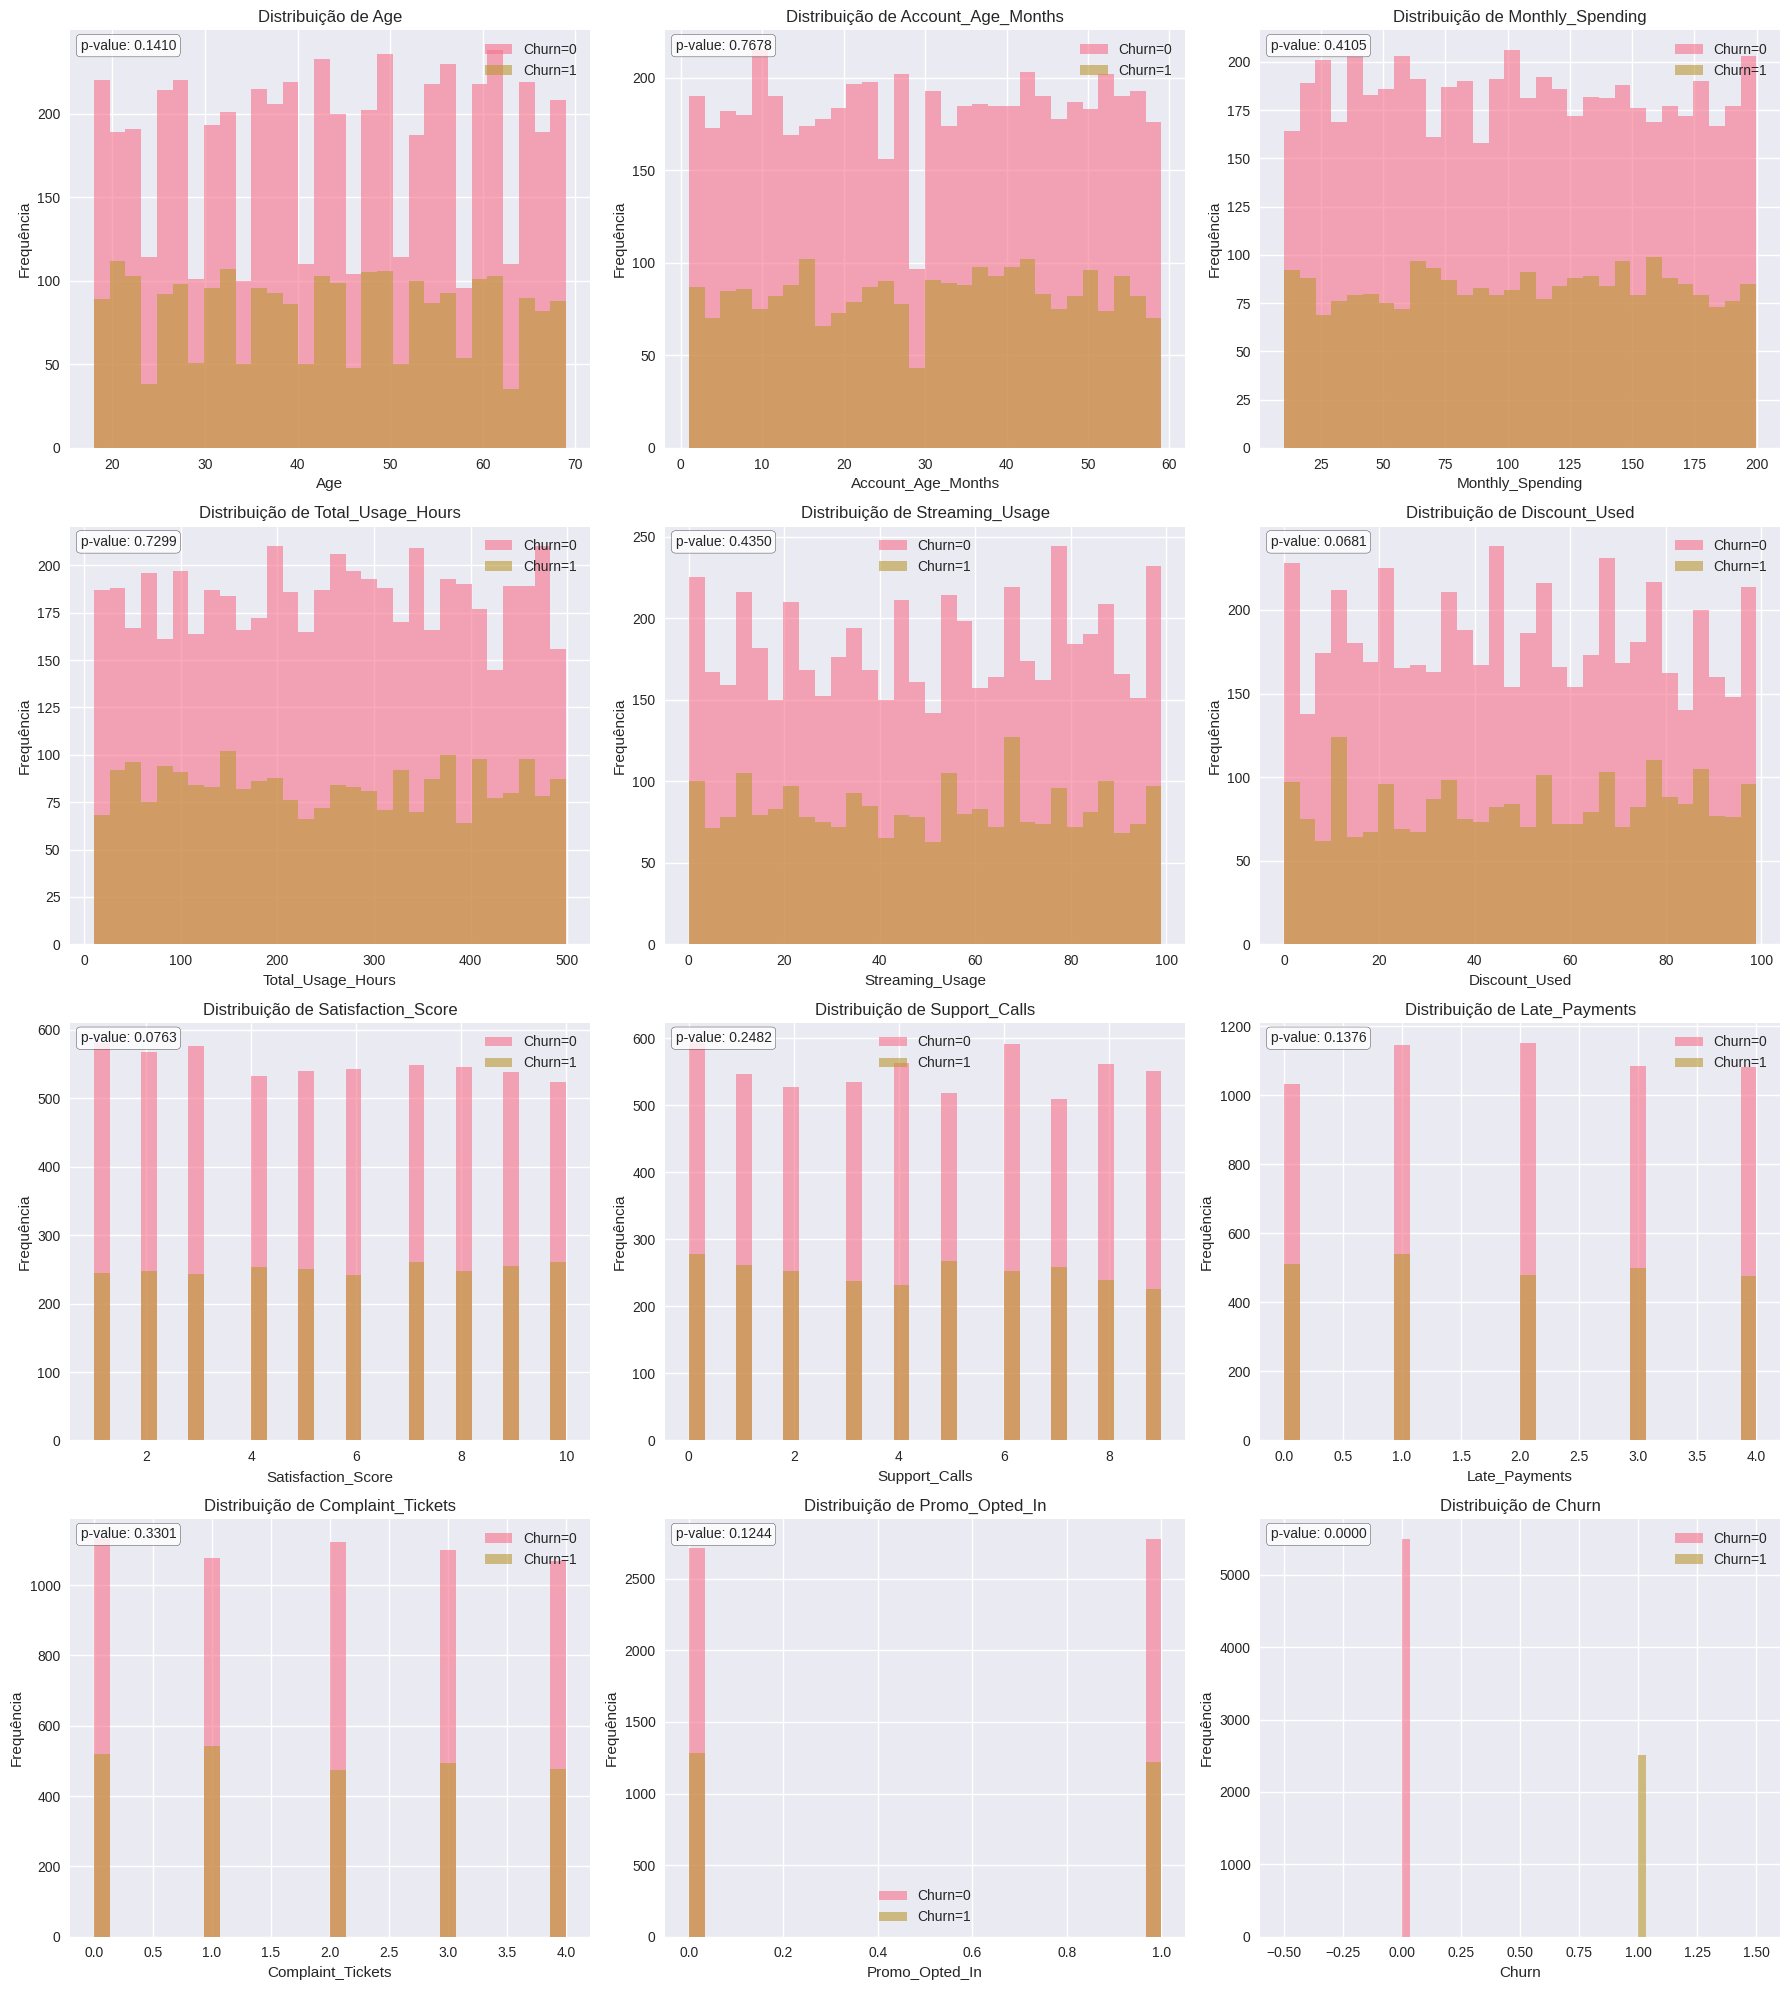


4. Boxplots por Target


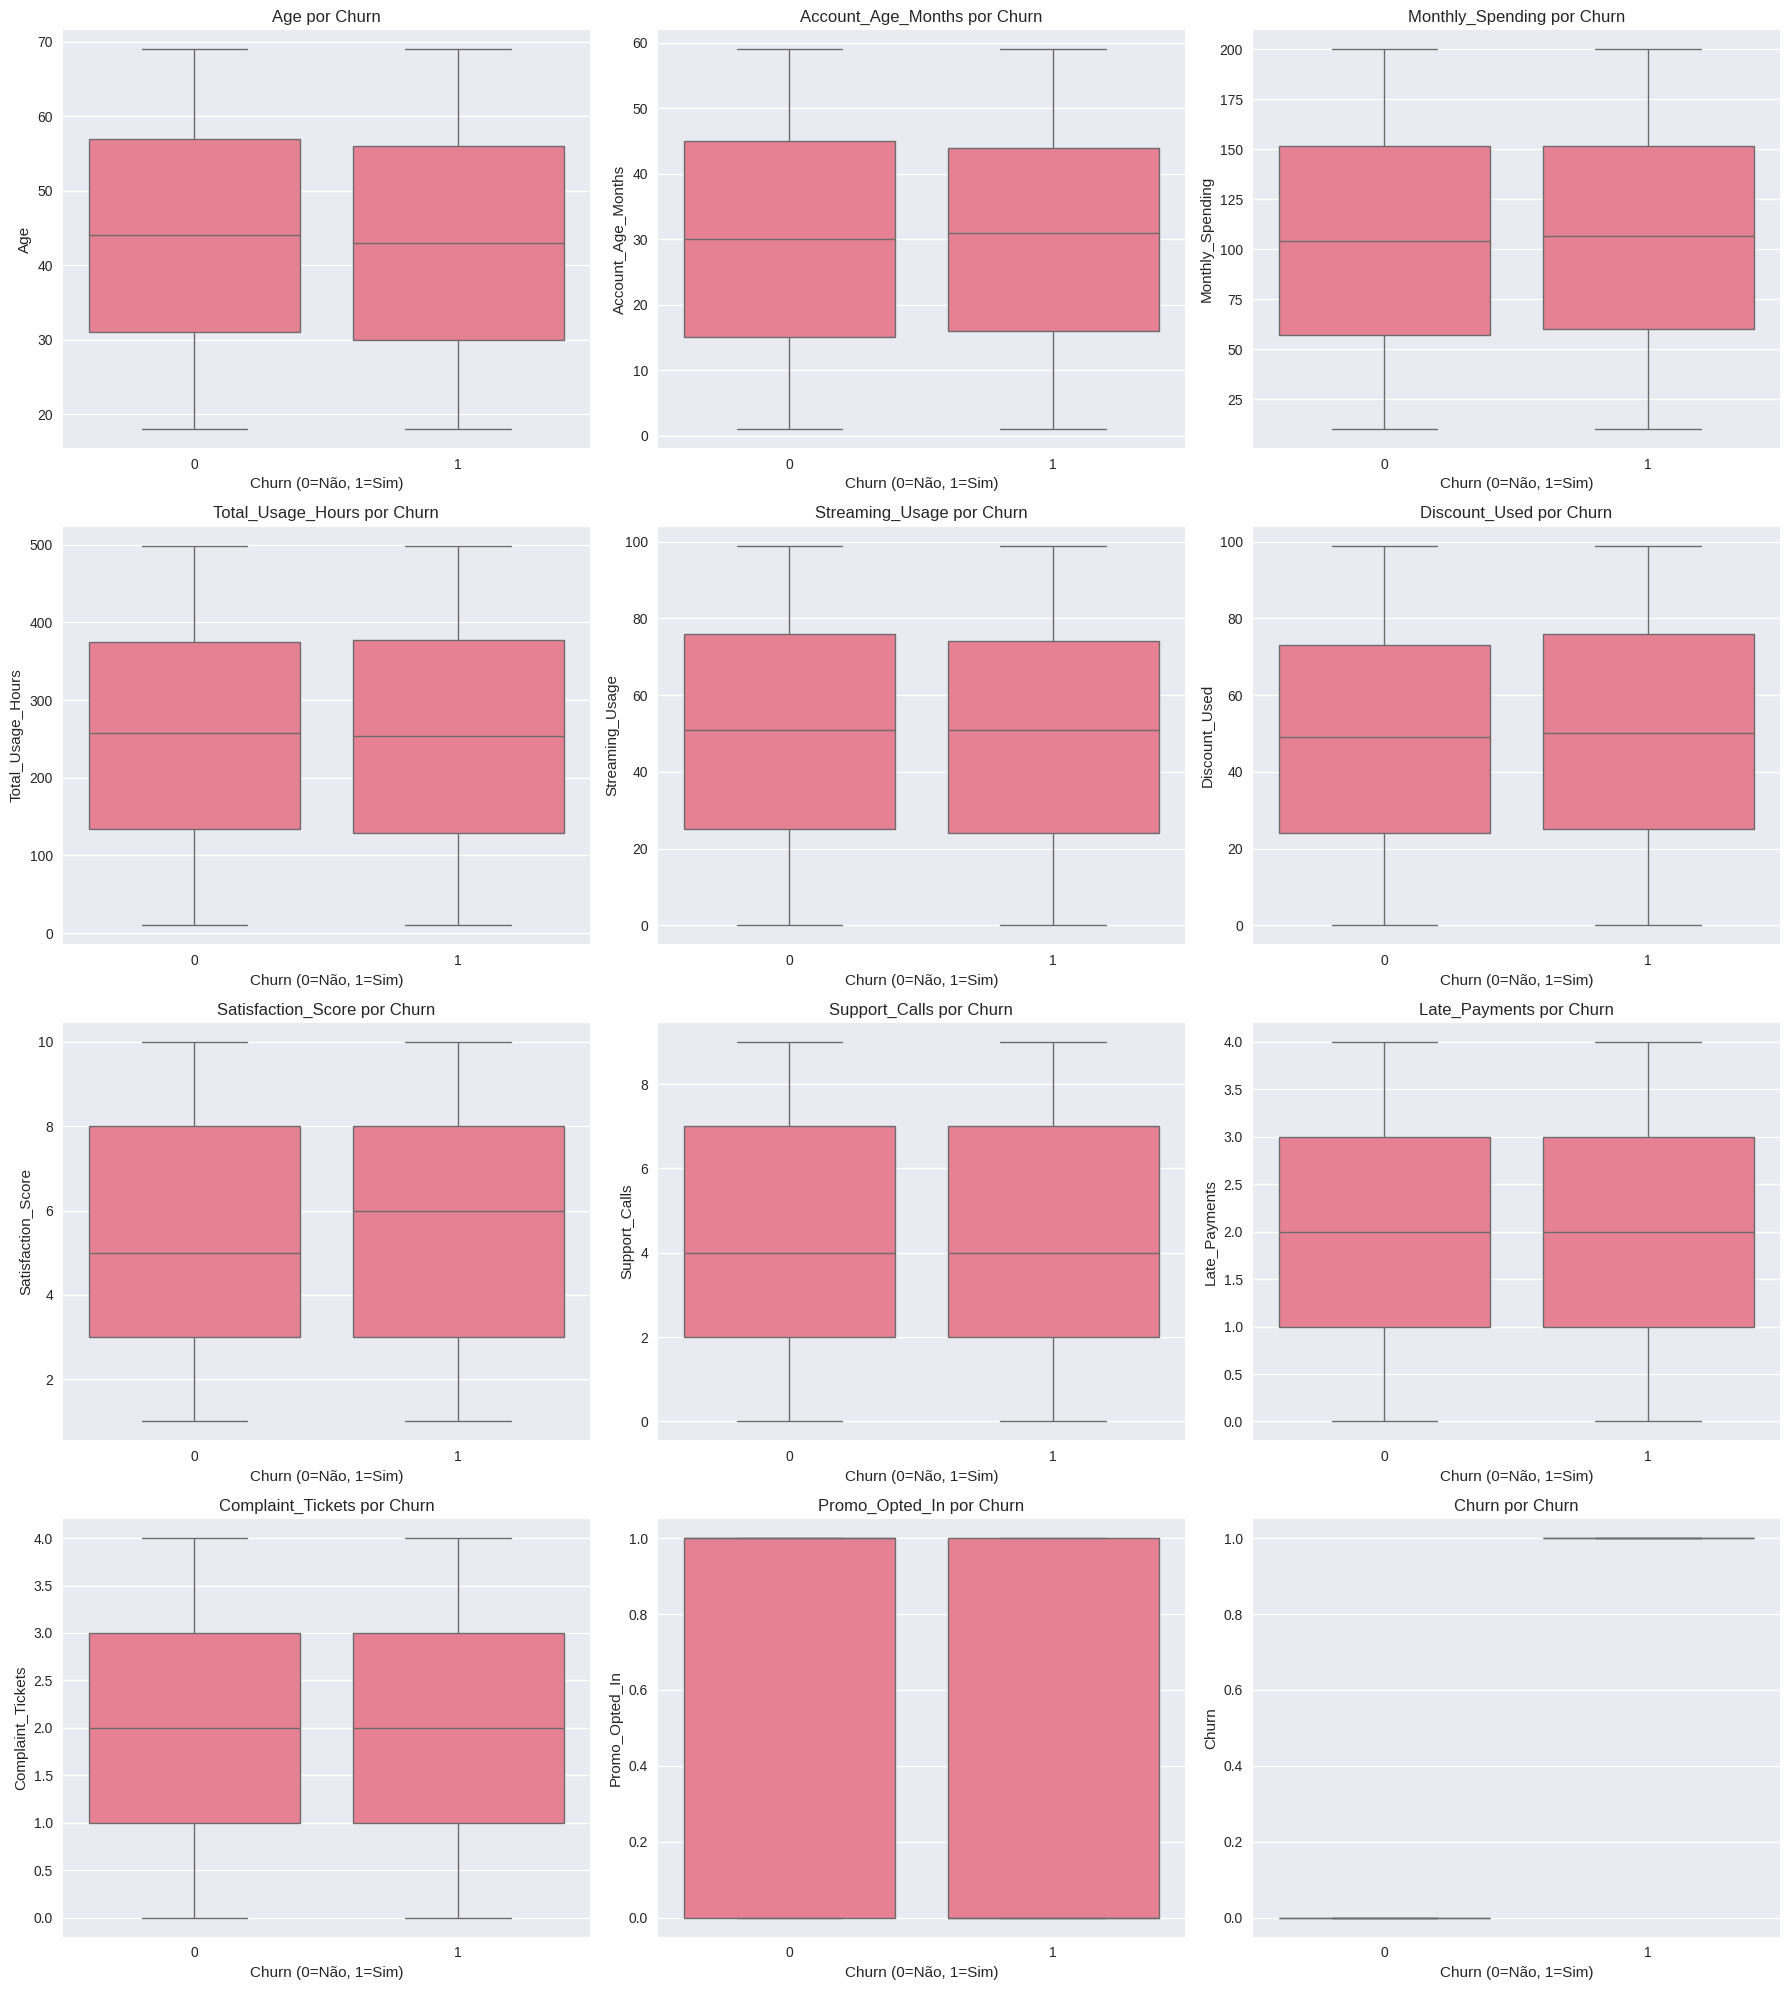


5. Matriz de Correlação


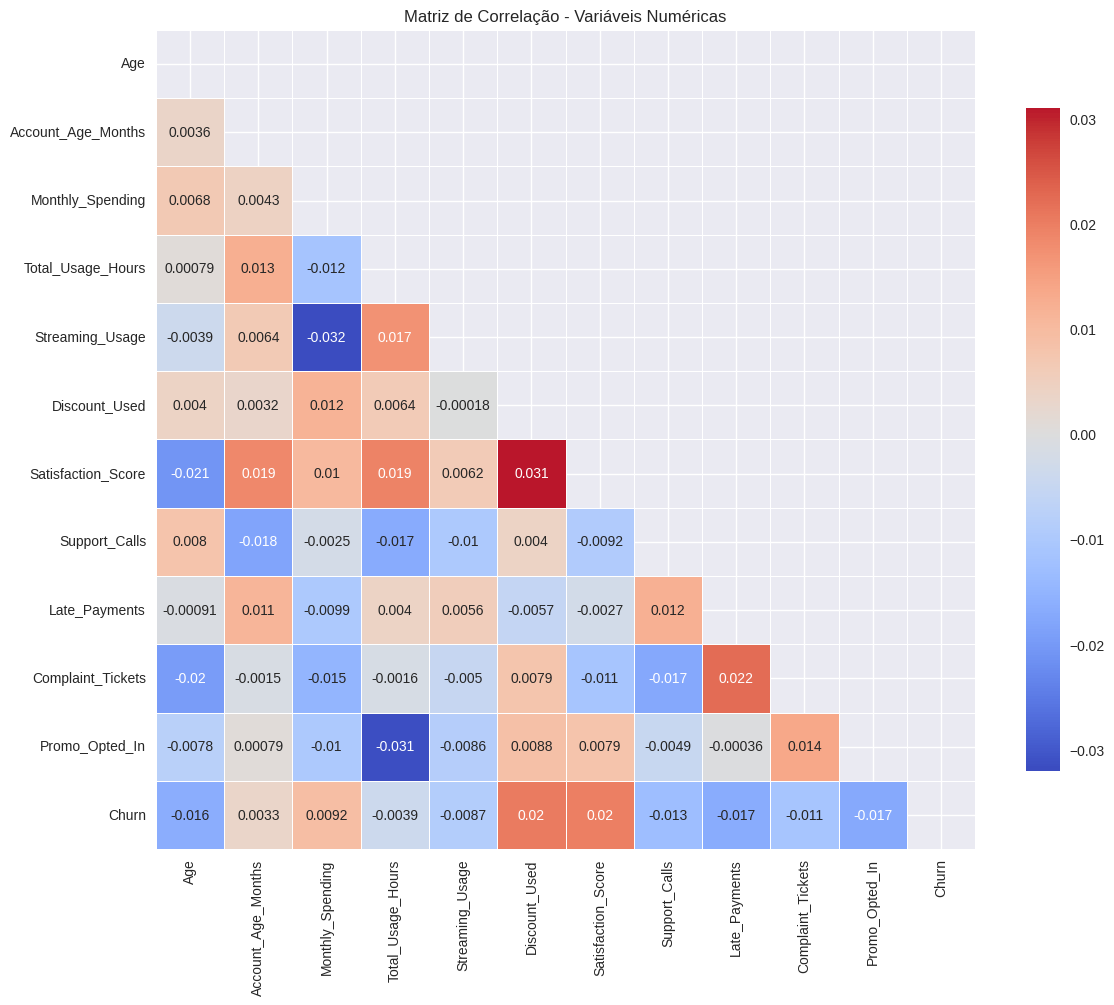


Top 10 correlações com Churn:
Churn                 1.000000
Discount_Used         0.020400
Satisfaction_Score    0.019819
Promo_Opted_In        0.017182
Late_Payments         0.016602
Age                   0.016458
Support_Calls         0.012913
Complaint_Tickets     0.010890
Monthly_Spending      0.009202
Streaming_Usage       0.008729
Name: Churn, dtype: float64

6. Pairplot - Variáveis Importantes


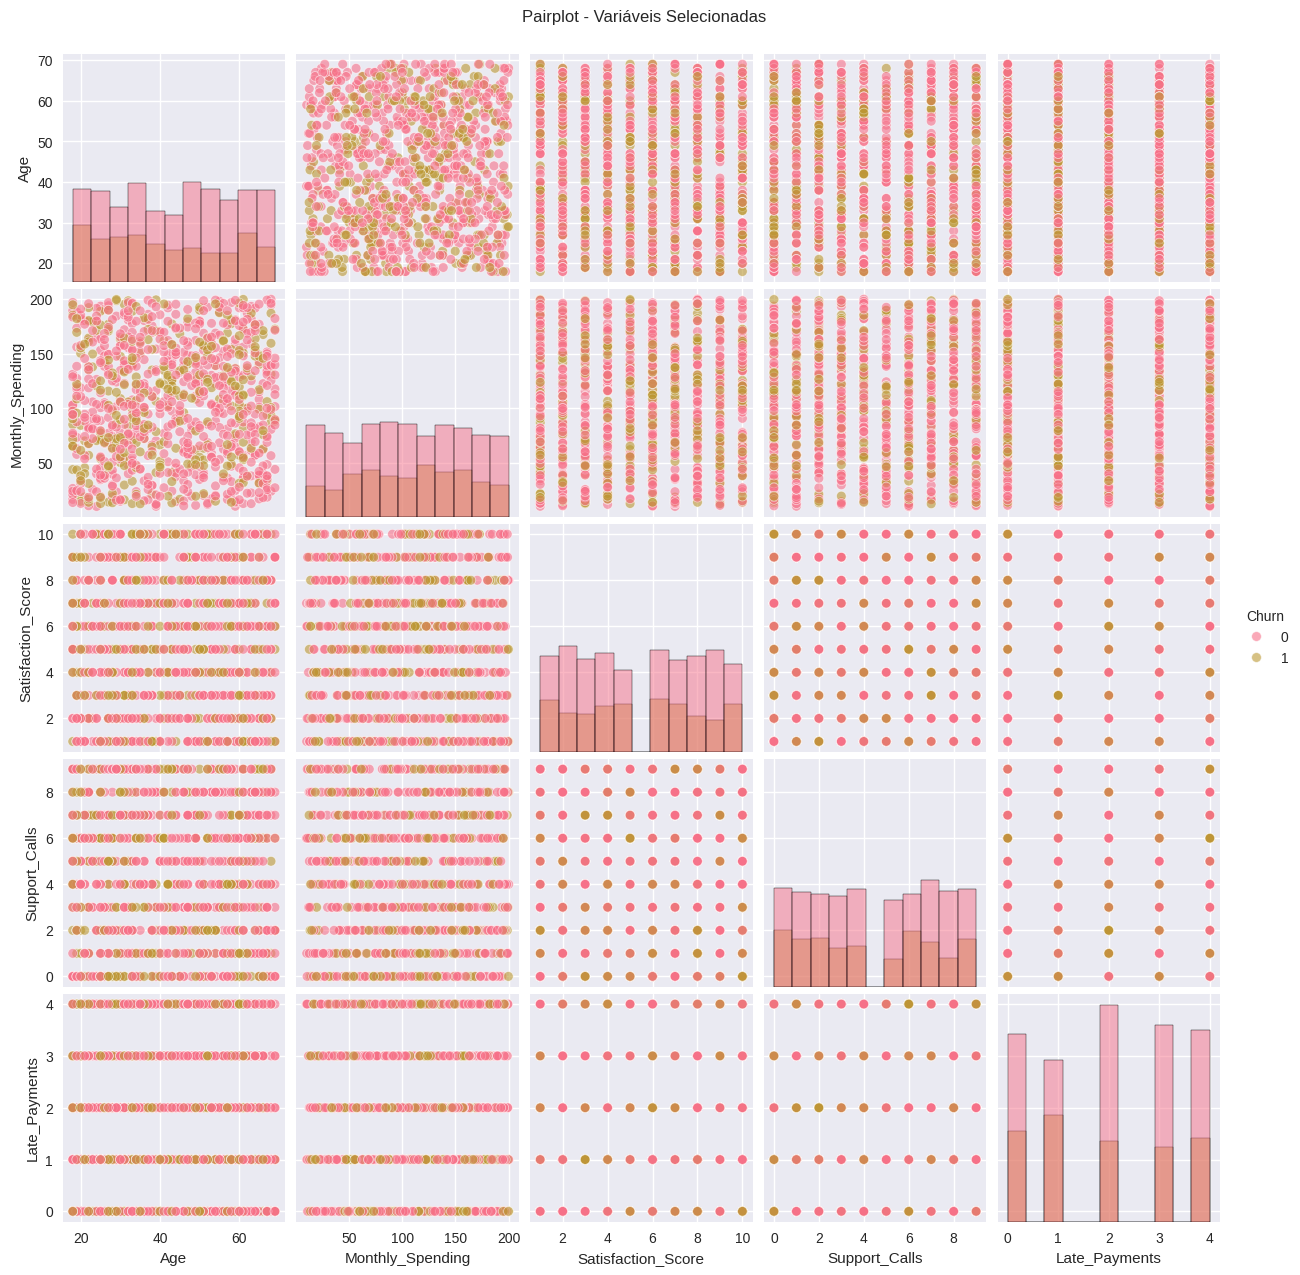


=== ANÁLISE CONCLUÍDA ===


In [8]:
# Executar análise completa
comprehensive_eda(df)

### Conclusões da analise exploratoria

1. O dataset não tem dados faltantes, então para o treinamento, não foi necessario imputar informações em valores nulos. Talvez seja necessario revisitar já que o dataset de teste pode ter dados nulos. 
2. A correlação entre as váriaveis de forma independente não tem uma boa correlação com o churn, então teremos que apostar em um conjunto de relações para tentar predizer o churn.
3. Existe uma quantidade satisfatoria de dados de cada categoria da target (churn) então técnicas de para equilibrar as classes não devem ser necessarias.
4. Tem poucas variaveis numericas e sem outliers explicitos
